<h2> Introduction </h2>

In this kernel, we will use Gausian Process Regressions and Bayesian Optimisation on ecoacoustic metrics to quantify the spatiotemporal distribution of birds on-farm. The data was obtained by placing 20 audio recorders across the property in a grid formation. The biodiversity project was set up in 14 and 15th Nov 2019.


<h2> Our Goals </h2>

<ul>
<li> Understand the spatial and temporal variability in the data, in particular, study how avian species richness change, examine if there are seasonal cycles.
<li> Determine the optimal placement of the 20 audio recorders using the previously described methods. </li>
<li> Determine what the optimal placement would be if one or more of the recorders were to stop functioning. </li>
</ul>


<h2> Outline </h2>

I. <b>Our Toolbox</b><br>
a) [The PreProcessing Class](#preprocessingclass)<br>
b) [The EcouacousticModel Class](#ecoacousticmodelclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(i) [The SingleFrameGaussianProcessModel Class](#singlegpclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(ii) [The FullGaussianProcessModel Class](#fullgpclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(iii) [The TSModel Class](#tsmodelclass)<br>
e) [The Visualise Class](#visualiseclass)<br>

II. <b>Understanding our data</b><br>
b) [Initializing and pre-processing our data](#initializing)<br>
b) [Gathering sense of our data](#gather)<br>


III. <b>Gaussian Process Regression spatiotemporal predictions</b><br>
a) [Picture: single timeframe spatial gaussian process regression predictions](#singlegp)<br>
b) [Video: spatiotemporal gaussian process regression predictions over the whole timeframe](#fullgp)<br>


IV. <b>Understanding the spatial and temporal variability in avian richness</b><br>
a) [Timeseries analysis](#tsmodel)<br>
b) [Spatiotemporal analysis?](#spatiotemporal)<br>

In [274]:
import warnings
import datetime as dt

import pandas as pd
import numpy as np
import statsmodels.api as sm

from os.path import exists
from itertools import product

from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.holtwinters import ExponentialSmoothing

warnings.filterwarnings("ignore")

<h2> I. Our Toolbox </h2>
<a id="preprocessingclass"></a>

<h3>a) The PreProcessing Class</h3>

-Explanation here-

In [2]:
class PreProcessing:
    def __init__(self,data_name,metadata_name,data_type):
        self.instrument_data = pd.read_csv(data_name)
        self.instrument_metadata = pd.read_csv(metadata_name)
        self.names = np.unique(self.instrument_data['name'])
        self.formatted_data = self.format_data(data_type)
        self.current_data = self.formatted_data
        self.get_metadata()
        
    def get_metadata(self):
        metadata = self.instrument_metadata.set_index('instrument_name').sort_index()
        self.current_metadata = metadata.loc[self.names]
        return self.current_metadata
        
    def get_names(self):
        return list(self.current_data.columns)
    
    def get_single_frame_data(self,data,index):        
        data = data.iloc[index]
        lats,longs = [],[]
        for name in self.names:
            lats.append(self.current_metadata['latitude'][name])
            longs.append(self.current_metadata['longitude'][name])

        single_frame_data = pd.DataFrame({'long':longs,'lat':lats,'val':data.values})
        
        return single_frame_data
    
    def get_data_for_full_gp(self,data,av_each_date = True):
        
        lats, longs, times,vals = [],[],[],[]
        
        for name in self.names:
            for time in data[name].index:
                lats.append(self.current_metadata['latitude'][name])
                longs.append(self.current_metadata['longitude'][name])
                times.append(time)
                vals.append(data[name][time])
                
        data_for_gp = pd.DataFrame({'long':longs,'lat':lats,'time':times,'val':vals})
        
        if av_each_date:
            data_for_gp['time'] = data_for_gp.time.apply(lambda x: dt.datetime.timestamp(dt.datetime(x.year,x.month,x.day)))
        else:
            data_for_gp['time'] = data_for_gp.time.apply(lambda x: dt.datetime.timestamp(dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')))

        return data_for_gp
    
    def get_single_site_data(self,data,name):
        return data[name]
        
    def format_data(self,data_type):
        diversity_index = self.instrument_data[self.instrument_data['type']==data_type]
        self.all_times = np.unique(diversity_index['timeStart'])
        
        grouped = diversity_index.groupby(['timeStart','name'], as_index=False).sum()
        grouped = grouped.drop('instrument_id', axis=1)
        pivoted = grouped.pivot(index="timeStart", columns="name").reset_index(drop=True)
        formatted_data = pivoted.droplevel(level=0, axis=1)
        formatted_data.columns.name = None
        formatted_data.fillna(0, inplace=True)

        return formatted_data
    
    def remove_plot(self):
#         This could be improved upon by looking at the intersections
        max_num_zeros = 0
        name_max_num_zeros = ''
        for name in self.names:
            num_zeros = (self.current_data[name]==0).sum()
            if num_zeros > max_num_zeros:
                max_num_zeros = num_zeros
                name_max_num_zeros = name
        self.current_data = self.current_data.drop(columns = [name_max_num_zeros])
        self.names = self.get_names()
        
    def get_sections(self,current_data,name):
        bool_zeros = current_data[:][name].values==0
        toggle = 2
        toggle_array=[]
        non_zero_sections = []
        zero_sections = []
        for i in range(bool_zeros.size):
            if toggle!=bool_zeros[i]:
                toggle = bool_zeros[i]
                toggle_array.append(i)
                if toggle and len(toggle_array)>1:
                    non_zero_sections.append([toggle_array[-2],i])
                elif not toggle and len(toggle_array)>2:
                    zero_sections.append([toggle_array[-2],toggle_array[-1]])
            if i == bool_zeros.size-1:
                if toggle:
                    zero_sections.append([toggle_array[-1],i])
                else:
                    non_zero_sections.append([toggle_array[-1],i])

        return non_zero_sections,zero_sections

    def get_overlapping_intersections(self,current_data):
        all_non_zero_sections = []
        for name in self.names:
            _,zero_sections = self.get_sections(current_data,name)
            for i in range(len(zero_sections)):
                len_section = zero_sections[i][1]-zero_sections[i][0] + 1
                if len_section < 20:
                    self.current_data[name][zero_sections[i][0]:zero_sections[i][1]] = np.nan

            non_zero_sections,_ = self.get_sections(current_data,name)
            all_non_zero_sections.append(non_zero_sections)           
        intersections = self.get_intersections(all_non_zero_sections)
        return intersections

    def get_intersection(self,range_1,range_2):
        x = range(range_1[0],range_1[1])
        y = range(range_2[0],range_2[1])
        xs = set(x)
        inter = xs.intersection(y)
        if len(inter) == 0:
            return []
        return [min(list(inter)),max(list(inter))+1]

    def get_intersections(self,all_non_zero_sections):
        final_set = []
        for i in range(len(all_non_zero_sections[0])):
            base_set = [all_non_zero_sections[0][i]]
            if len(all_non_zero_sections)>1:
                for j in range(1,len(all_non_zero_sections)):
                    new_set = []
                    # Loop over values in base_set
                    for k in range(len(base_set)):
                        # Loop over values in each section
                        for l in range(len(all_non_zero_sections[j])):
                            inter = self.get_intersection(base_set[k],all_non_zero_sections[j][l])
                            if len(inter) != 0:
                                new_set.append(inter)
                    base_set = new_set
            for b_set in base_set:
                final_set.append(b_set)
        return final_set
    
    def get_current_cleaned_data(self):
        ranges = self.get_overlapping_intersections(self.current_data)
        diff_r = []
        for r in ranges:
            diff_r.append(r[1]-r[0])
        max_range_idx = np.argmax(diff_r)
        cleaned_data = self.current_data.iloc[ranges[max_range_idx][0]:ranges[max_range_idx][1]]
        cleaned_and_interpolated_data = self.interpolate_data(cleaned_data)
        self.current_cleaned_data = cleaned_data
        
        cleaned_data['time'] = self.all_times[ranges[max_range_idx][0]:ranges[max_range_idx][1]]
        cleaned_data = cleaned_data.set_index('time')

        return cleaned_data
    
    def interpolate_data(self,data):
        for name in self.names:
            data[name] = data[name].interpolate()
        return data
    
    def get_current_cleaned_date_data(self,df):
        df = df.reset_index()
        df['time'] = df['time'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
        df['time'] = df.time.dt.date
        self.current_cleaned_date_data = df.groupby('time', as_index=False).mean().set_index('time')
        return self.current_cleaned_date_data
    
    def get_av_period(self,df):
        df = df.reset_index()
        df['time'] = df['time'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
        df['time'] = df.time.dt.date
        df = df.groupby('time', as_index=False).count()
        df = df['A01']
        return int(np.round(np.mean(df.values),0))

<a id="ecoacousticmodelclass"></a>

<h3>b) The EcoacousticModel class</h3>

-Explanation here-

In [3]:
class EcoacousticModel:
    def __init__(self):
        print('Initializing Model')
        
    def save_results(self,fig,filename):
        if exists(filename):
            print('This file already exists')
        else:
            fig.savefig(filename)

<a id="singlegpclass"></a>

<h4>b) (i) The SingleFrameGaussianProcessModel class</h4>

-Explanation here-

In [4]:
class SingleFrameGaussianProcessModel(EcoacousticModel):   
    def __init__(self, single_frame_data,title,n_points = 100):
        super().__init__()
        self.n_points = n_points

        self.X = single_frame_data[['long','lat']].values
        self.y = single_frame_data.val.values

        # Input space
        x1 = np.linspace(np.min(single_frame_data.long), np.max(single_frame_data.long),n_points) #p
        x2 = np.linspace(np.min(single_frame_data.lat), np.max(single_frame_data.lat),n_points) #q
        self.x = (np.array([x1, x2])).T
        self.x1x2 = np.array(list(product(x1, x2)))
        self.X0p, self.X1p = self.x1x2[:,0].reshape(n_points,n_points), self.x1x2[:,1].reshape(n_points,n_points)

        kernel = RBF([1,1], (1e-2, 1e-2))
        self.gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
        
        self.title = str(title)
        
        self.path = './results/GPs/single_frames/'
        self.filename = self.path + 'single_frame_gp_'+str(self.X.shape[0])+'_stations_at_'+self.title +'.png'

    def run(self,save=False):
        self.gp.fit(self.X, self.y)

        self.y_pred, self.MSE = self.gp.predict(self.x1x2, return_std=True)

        self.y_lower = self.y_pred - 2*self.MSE
        self.y_higher = self.y_pred + 2*self.MSE

        Zp_mean = np.reshape(self.y_pred,(self.n_points,self.n_points))
        Zp_lower = np.reshape(self.y_lower,(self.n_points,self.n_points))
        Zp_higher = np.reshape(self.y_higher,(self.n_points,self.n_points))

        self.vmin = np.min(self.y_lower)
        self.vmax = np.max(self.y_higher)

        fig, ax = plt.subplots(1,3,figsize=(20,4))

        ax[1].pcolormesh(self.X0p, self.X1p, Zp_mean,vmin=self.vmin,vmax=self.vmax,cmap='RdBu_r')
        ax[1].scatter(single_frame_data.long,single_frame_data.lat,s = single_frame_data.val*100,c='g')
        ax[1].title.set_text('μ')
        ax[1].set_xlabel('Longitude')
        ax[1].set_ylabel('Latitude')
        
        ax[0].pcolormesh(self.X0p, self.X1p, Zp_lower,vmin=self.vmin,vmax=self.vmax,cmap='RdBu_r')
        ax[0].scatter(single_frame_data.long,single_frame_data.lat,s = single_frame_data.val*100,c='g')
        ax[0].title.set_text('-2σ')
        ax[0].set_xlabel('Longitude')
        ax[0].set_ylabel('Latitude')
        
        ax[2].pcolormesh(self.X0p, self.X1p, Zp_higher,vmin=self.vmin,vmax=self.vmax,cmap='RdBu_r')
        ax[2].scatter(single_frame_data.long,single_frame_data.lat,s = single_frame_data.val*100,c='g')
        ax[2].title.set_text('+2σ')
        ax[2].set_xlabel('Longitude')
        ax[2].set_ylabel('Latitude')
        
        fig.suptitle(str(self.title))
        
        if save:
            self.save_results(fig,self.filename)
        plt.show()

<a id="fullgpclass"></a>

<h4>b) (ii) The FullGaussianProcessModel class</h4>

-Explanation here-

In [5]:
class FullGaussianProcessModel(EcoacousticModel): 
#         filename = 
    def __init__(self, data_for_gp, n_points = 50):
        super().__init__()
        self.n_points = n_points

        self.X = data_for_gp[['long','lat','time']].values
        self.y = data_for_gp.val.values

        # Input space
        x1 = np.linspace(np.min(data_for_gp.long), np.max(data_for_gp.long),n_points) #p
        x2 = np.linspace(np.min(data_for_gp.lat), np.max(data_for_gp.lat),n_points) #q
        x3 = np.linspace(np.min(data_for_gp.time), np.max(data_for_gp.time),data_for_gp.time.unique().size) #q

        self.x1x2x3 = np.array(list(product(x1, x2, x3)))

        self.gp = GaussianProcessRegressor(n_restarts_optimizer=15)
    
    def process_prediction(self):

        pred_df = pd.DataFrame({'y_pred':self.y_pred,'y_lower':self.y_lower,'y_higher':self.y_higher})
        cov_df = pd.DataFrame({'long':self.x1x2x3[:,0],'lat':self.x1x2x3[:,1],'time':self.x1x2x3[:,2]})
        
        df = pd.concat([pred_df, cov_df], axis=1)
        
        wide_ypred =  df.pivot_table(values=['y_pred'], index= ['long','lat'],columns='time')
        wide_ypred = wide_ypred.droplevel(level=0, axis=1)
        wide_ypred.columns.name = None
        
        wide_ylower =  df.pivot_table(values=['y_lower'], index= ['long','lat'],columns='time')
        wide_ylower = wide_ylower.droplevel(level=0, axis=1)
        wide_ylower.columns.name = None
        
        wide_yhigher =  df.pivot_table(values=['y_higher'], index= ['long','lat'],columns='time')
        wide_yhigher = wide_yhigher.droplevel(level=0, axis=1)
        wide_yhigher.columns.name = None
        
        return wide_ypred, wide_ylower, wide_yhigher
        
    def create_animation(self,pred,lower,higher):
        long_lats = np.array([list(item) for item in pred.index])     
        X0, X1 = long_lats[:,0].reshape(self.n_points,self.n_points), long_lats[:,1].reshape(self.n_points,self.n_points)

        
        fig, ax = plt.subplots(1,3,figsize=(20,4))

        lower_plot = ax[0].pcolormesh(X0, X1, np.reshape(lower[lower.columns[0]].values,(self.n_points,self.n_points)),vmin=self.vmin,vmax=self.vmax)
        pred_plot = ax[1].pcolormesh(X0, X1, np.reshape(pred[pred.columns[0]].values,(self.n_points,self.n_points)),vmin=self.vmin,vmax=self.vmax)
        higher_plot = ax[2].pcolormesh(X0, X1, np.reshape(higher[higher.columns[0]].values,(self.n_points,self.n_points)),vmin=self.vmin,vmax=self.vmax)
        
        fig.colorbar(pred_plot)

        def animate(i):
            lower_plot.set_array(np.reshape(lower[lower.columns[i+1]].values,(self.n_points,self.n_points)).flatten())
            pred_plot.set_array(np.reshape(pred[pred.columns[i+1]].values,(self.n_points,self.n_points)).flatten())
            higher_plot.set_array(np.reshape(higher[higher.columns[i+1]].values,(self.n_points,self.n_points)).flatten())

        anim = FuncAnimation(fig, animate, interval=100, frames=pred.shape[1] - 1)
        anim.save('517.gif')
        plt.show()
    
    def run(self):
        self.gp.fit(self.X, self.y)

        self.y_pred, self.MSE = self.gp.predict(self.x1x2x3, return_std=True)

        self.y_lower = self.y_pred - 2*self.MSE
        self.y_higher = self.y_pred + 2*self.MSE

        self.vmin = np.min(self.y_lower)
        self.vmax = np.max(self.y_higher)
        
        wide_ypred, wide_ylower, wide_yhigher = self.process_prediction()
        
        self.create_animation(wide_ypred, wide_ylower, wide_yhigher)


# Testing

In [6]:
preprocessor = PreProcessing('data/instrument_data.csv','data/instrument_metadata.csv','ADI')
preprocessor.remove_plot()
metadata = preprocessor.get_metadata()
ecoacoustic_data = preprocessor.get_current_cleaned_data()
ecoacoustic_date_data = preprocessor.get_current_cleaned_date_data(ecoacoustic_data)
period = preprocessor.get_av_period(ecoacoustic_data)

Initializing Model


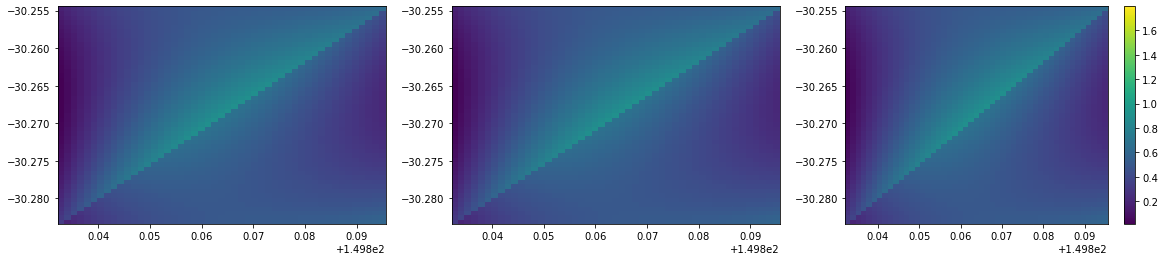

In [7]:
data_for_gp = preprocessor.get_data_for_full_gp(ecoacoustic_date_data,av_each_date = True)
FullGaussianProcessModel(data_for_gp).run()

<a id="svdmodelclass"></a>

<h4>b) (iii) The SVDModel class</h4>

-Explanation here-

Will be used to visualise modes of the full Gaussian process

In [8]:
class SVDModel(EcoacousticModel): 
#         filename = 
    def __init__(self, data_from_full_gp):
        super().__init__()
        self.n_points = n_points
        


<a id="tsmodelclass"></a>

<h4>b) (iv) The TSModel class</h4>

-Explanation here-

In [381]:
class TSModel(EcoacousticModel): 
#         filename = 
    def __init__(self, single_site_data, period, test_ratio=0.3):
        super().__init__() 
        self.period = period
        self.single_site_data = single_site_data
        self.T = single_site_data.shape[0]
        self.train_data, self.test_data = self.split_train_test(test_ratio)    
    
    def split_train_test(self, test_ratio=0.3):
        indices = self.single_site_data.index.values
        train_indices = indices[:int(self.T*(1-test_ratio))]
        test_indices = indices[int(self.T*(1-test_ratio)):]
        
        train_data = self.single_site_data[train_indices]
        test_data = self.single_site_data[test_indices]
        
        return train_data, test_data       
        
        
    def seasonal_decompose(self):
        #decomposition = sm.tsa.seasonal_decompose(self.single_site_data, model='additive',
        #                                          extrapolate_trend='freq',
        #                                          period=self.period)
        decomposition = STL(self.single_site_data, period=self.period).fit()
        fig = decomposition.plot()
        fig.set_size_inches(14,7)
        plt.show()
        
        return decomposition
    
    def plot_autocorrelations(self, y, plot_lims=True):
        ac = sm.tsa.stattools.acf(y)
        x = range(1, len(ac)+1)
        plt.figure()
        plt.bar(x, ac)
        if plot_lims:
            plt.axhline(y=2/np.sqrt(self.T), color='r', linestyle='--', alpha=0.5, label='$2/\sqrt{T}$')
            plt.axhline(y=-2/np.sqrt(self.T), color='r', linestyle='--', alpha=0.5, label='$-2/\sqrt{T}$')
        plt.xlabel('i')
        plt.ylabel('ρ_i')
        plt.legend()
        plt.show()
    
    def make_ts_stationary(self, y):
        pass
        
        
    def fit_model(self, model='ETS', verbose=False, **kwargs):
        
        self.model = model
        
        if model=='ETS':

            ## Define the ETS Model
            ets_model = ExponentialSmoothing(
                self.train_data,
                trend='additive',
                seasonal='additive',
                seasonal_periods=24
            )

            ## Fit model
            self.fitted_model = ets_model.fit()

            if verbose:
                print('')
                print('== Holt-Winters Additive ETS(A,A,A) Parameters ==')
                print('')
                alpha_value = np.round(fitted_model.params['smoothing_level'], 4)
                print('Smoothing Level: ', alpha_value)
                print('Smoothing Slope: ', np.round(fitted_model.params['smoothing_slope'], 4))
                print('Smoothing Seasonal: ', np.round(fitted_model.params['smoothing_seasonal'], 4))
                print('Initial Level: ', np.round(fitted_model.params['initial_level'], 4))
                print('Initial Slope: ', np.round(fitted_model.params['initial_slope'], 4))
                print('Initial Seasons: ', np.round(fitted_model.params['initial_seasons'], 4))
                print('')
        
        elif model=='ARIMA':
            
            # fit model
            model = ARIMA(
                self.train_data, 
                order=(kwargs.get('p', self.period), 
                       kwargs.get('d', 0), 
                       kwargs.get('q', 0)
                      )
            )
            self.fitted_model = model.fit()

            # summary of fit model
            print(self.fitted_model.summary())

            # line plot of residuals
            residuals = pd.DataFrame(self.fitted_model.resid)
            self.plot_autocorrelations(residuals)

            # density plot of residuals
            residuals.plot(kind='kde')
            plt.show()

            # summary stats of residuals
            print(residuals.describe())
            
    def get_one_period_ahead_pred(self, **kwargs):
        
        # Preds
        preds = []
        updated_data = self.train_data.copy()
        
        # Iterate indicies for periods
        for i in tqdm(range(0, len(self.test_data.index), self.period)):
            
            # Define model
            model = ARIMA(
                updated_data, 
                order=(kwargs.get('p', self.period), 
                       kwargs.get('d', 0), 
                       kwargs.get('q', 0)
                      )
            )

            # Fit ARIMA model
            fitted_model = model.fit()
            
            # Get test samples
            indices = self.test_data.index[i: min(i+self.period, len(self.test_data))]
            test_samples = self.test_data[indices]
            
            # Forecast on test indices
            y_hat = fitted_model.forecast(steps=len(indices))
            
            # Store results in dataframe along with confidence interval
            df_pred = fitted_model.get_forecast(len(indices)).conf_int(0.1)
            df_pred.columns = ['5%', '95%']
            df_pred.loc[:, 'y_hat'] = y_hat
            df_pred.loc[:, 'y'] = test_samples
            
            # Append preds
            preds.append(df_pred)
            
            # Update train dataset with period data
            updated_data = pd.concat([updated_data, test_samples], axis=0)
        
        # Concatenate results for all periods
        df_test_pred = pd.concat(preds, axis=0)
 
        # Plot predictions
        fig, ax = plt.subplots(figsize=(20, 5))
        plt.plot(df_test_pred.loc[:, 'y'], label='y', c='tab:red')
        plt.plot(df_test_pred.loc[:, 'y_hat'], label='y_hat', c='tab:green')
        plt.plot(df_test_pred.loc[:, '5%'], label='5%', color='g', linestyle='--', alpha=0.5)
        plt.plot(df_test_pred.loc[:, '95%'], label='95%', color='g', linestyle='--', alpha=0.5)
        plt.fill_between(df_test_pred.index, df_test_pred.loc[:, '5%'], df_test_pred.loc[:, '95%'], 
                         color='g', alpha=0.25)
        plt.legend()
        
        ## Residuals
        df_test_pred.loc[:, 'resid'] = df_test_pred.y_hat - df_test_pred.y
        self.plot_autocorrelations(df_test_pred.resid)
        
        return df_test_pred

    def evaluate(self):
                
        ## Forecast for test samples    
        y_hat =  self.fitted_model.forecast(steps=len(self.test_data))
        
        if self.model=='ARIMA':
            df_test_pred = self.fitted_model.get_forecast(len(self.test_data)).conf_int(0.1)
            df_test_pred.columns = ['5%', '95%']
            df_test_pred.loc[:, 'y_hat'] = y_hat
            df_test_pred.loc[:, 'y'] = self.test_data
        else:
            df_test_pred = pd.DataFrame({'y_hat':y_hat,'y':self.test_data})
        
        
        ## Plot predictions
        fig, ax = plt.subplots(figsize=(20, 5))
        if self.model == 'ARIMA':
            plt.plot(df_test_pred.loc[:, 'y'], label='y', c='tab:red')
            plt.plot(df_test_pred.loc[:, 'y_hat'], label='y_hat', c='tab:green')
            plt.plot(df_test_pred.loc[:, '5%'], label='5%', color='g', linestyle='--', alpha=0.5)
            plt.plot(df_test_pred.loc[:, '95%'], label='95%', color='g', linestyle='--', alpha=0.5)
            plt.fill_between(df_test_pred.index, df_test_pred.loc[:, '5%'], df_test_pred.loc[:, '95%'], 
                             color='g', alpha=0.25)
            plt.legend()
        else:
            df_test_pred.plot(ax=ax)
        
        ## Residuals
        df_test_pred.loc[:, 'resid'] = df_test_pred.y_hat - df_test_pred.y
        self.plot_autocorrelations(df_test_pred.resid)


In [382]:
ecoacoustic_data2 = ecoacoustic_data.reset_index()
ecoacoustic_data2.loc[:, 'time'] = pd.to_datetime(ecoacoustic_data2.loc[:, 'time'])
ecoacoustic_data2.set_index('time', inplace=True)
ecoacoustic_data2.head()

,A01,A02,A03,A05,A06,A07,A08,A09,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20
time,,,,,,,,,,,,,,,,,,,
2019-11-15 03:00:00,0.427916,0.060223,0.721362,0.033371,0.443423,1.181565,0.155228,0.270399,1.486626,0.487352,0.207718,0.822413,0.063603,0.182189,0.653726,0.606749,1.564877,0.129611,0.277871
2019-11-15 04:00:00,0.272271,0.260096,0.302241,0.130093,0.481952,0.941653,0.138064,0.153950,1.247101,0.279975,0.296190,0.352018,0.170126,0.173669,0.460510,0.585273,1.569356,0.357851,0.281680
2019-11-15 05:00:00,0.240162,0.667095,0.786355,0.159909,0.587540,0.543073,0.122935,0.282589,1.479015,0.467531,0.295206,0.269490,0.253091,0.123363,0.487644,0.842502,1.122792,0.402473,0.025240
2019-11-15 06:00:00,0.215272,0.128456,0.697012,0.077847,0.343951,0.603921,0.141965,0.279560,1.155387,0.162408,0.269655,0.218457,0.026571,0.128940,0.518657,0.295937,1.617385,0.270619,0.607108
2019-11-15 07:00:00,0.374148,0.199323,0.884591,0.098817,0.864420,1.249793,0.244635,0.239976,0.970906,0.095830,0.414681,0.247225,0.178865,0.167823,0.266510,0.476036,1.466675,0.079403,0.209249


Initializing Model


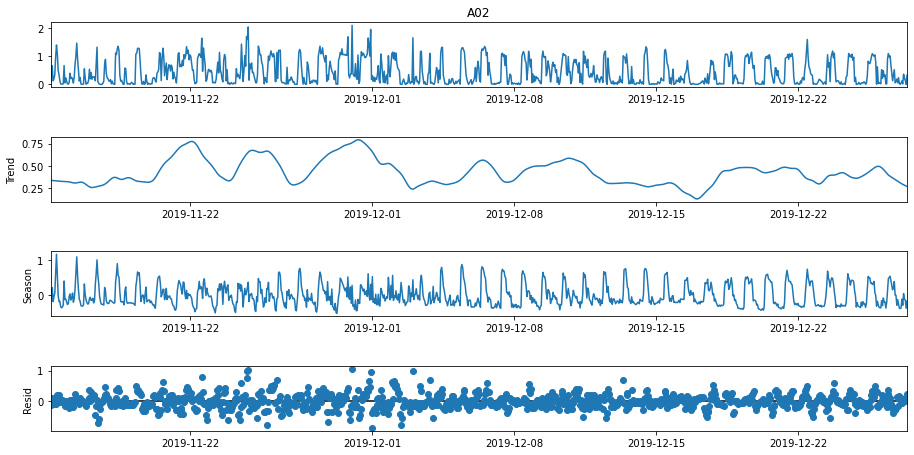

In [383]:
site = 'A02'
single_site_data = preprocessor.get_single_site_data(ecoacoustic_data2, site)

ts_model = TSModel(single_site_data, period=24)
decomposition = ts_model.seasonal_decompose()

In [384]:
# preds = ts_model.fit_model(model='ARIMA', d=1)
# ts_model.evaluate()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:48<00:00,  3.73s/it]


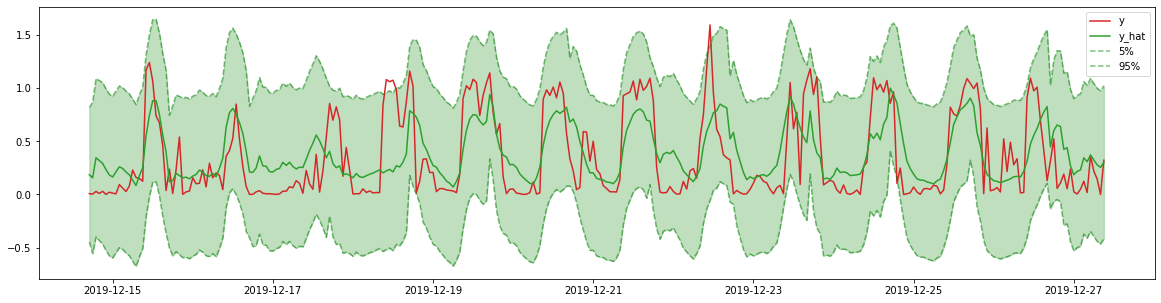

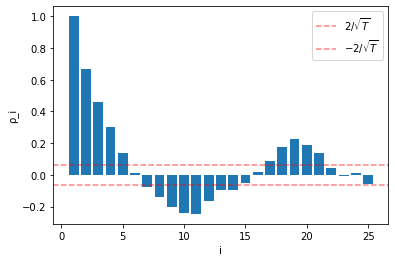

In [385]:
data = ts_model.get_one_period_ahead_pred()

<a id="visualiseclass"></a>

<h3>c) The Visualise class</h3>

-Explanation here-

In [14]:
class Visualise:
    def __init__(self,ecoacustic_data,metadata):
        self.ecoacoustic_data = ecoacoustic_data
        self.metadata = metadata
        self.names = list(self.ecoacoustic_data.columns)
        
    def plot_all_ts(self):
        for name in self.names:
            plt.figure(figsize=(15, 3))
            plt.plot(self.ecoacoustic_data[name].values)
            plt.title(name)
            plt.show()
    
    def point_animation(self):    
        fig,ax = plt.subplots()

        lats = []
        longs = []
        for name in self.names:
            lats.append(self.metadata['latitude'][name])
            longs.append(self.metadata['longitude'][name])

        scatter = ax.scatter(longs, lats,s=np.zeros(len(self.names)))

        def init():
            scatter.set_sizes(np.zeros(len(self.names)))
            return scatter

        def update(frame):
            data = frame
            scatter.set_sizes(data*100)
            return scatter

        anim = FuncAnimation(fig, update, interval=1,frames = self.ecoacoustic_data.values,init_func=init)
        
        filename = 'results/raw_data/station_animations/animation_of_' + str(len(self.names)) + '_plots.gif'
        anim.save(filename)

<h2> II. Understanding our data </h2>

<a id="initializing"></a>

<h3>a) Initializing and pre-processing our data</h3>

-Explanation here

In [15]:
preprocessor = PreProcessing('data/instrument_data.csv','data/instrument_metadata.csv','ADI')
preprocessor.remove_plot()
metadata = preprocessor.get_metadata()
ecoacoustic_data = preprocessor.get_current_cleaned_data()
ecoacoustic_date_data = preprocessor.get_current_cleaned_date_data(ecoacoustic_data)
period = preprocessor.get_av_period(ecoacoustic_data)

<a id="gathering"></a>

<h3>b) Gathering sense of our data</h3>

-Explanation here-

<h2> III. Gaussian Process Regression spatiotemporal predictions </h2>

<a id="singlegp"></a>

<h3>a) Picture: single timeframe spatial gaussian process regression predictions</h3>

-Explanation here-


In [16]:
# for i in range(5):
#     single_frame_data = preprocessor.get_single_frame_data(ecoacoustic_data,i)
#     SingleFrameGaussianProcessModel(single_frame_data,title = ecoacoustic_data.index[i]).run(True)

<a id="fullgp"></a>

<h3>a) Video: spatiotemporal gaussian process regression predictions over the whole timeframe</h3>

-Explanation here-

<h2> IV. Understanding the spatial and temporal variability in avian richness </h2>
<a id="tsmodel"></a>

<h3>a) Timeseries analysis </h3>

-Explanation here-

<a id="spatiotemporal"></a>

<h3>a) Spatiotemporal analysis </h3>

-Explanation here-

In [17]:
# visualiser = Visualise(ecoacoustic_data,metadata)
# visualiser.plot_all_ts()
# visualiser.point_animation()